# Wrangling and Assessing the Data -WeRateDogs


### Introduction

Data wrangling is a core skill that everyone who works with data should be familiar with since so much of the world's data isn't clean. We need to wrangle our data for good outcomes, otherwise there could be consequences. If we analyze, visualize, or model our data before we wrangle it, our consequences could be making mistakes, missing out on cool insights, and wasting time. So best practices say wrangle. Always.

Through this project will gather data from a variety of sources and in a variety of formats, assess its quality and tidiness, then clean it.

The dataset that we will be wrangling (and analyzing and visualizing) is the tweet archive of Twitter user @dog_rates, also known as WeRateDogs.

In [298]:
import pandas as pd
import datetime as dt
import numpy as np
import requests
import tweepy
import json
import re
from nltk import pos_tag
import time
import matplotlib.pyplot as plt


## Gathering Data

1. Twitter Archive Data from csv file.WeRateDogs Twitter archive provided to us via Udacity . We will download this      file manually from Udacity.

2. Image data from the given URL.-The tweet image predictions, i.e., what breed of dog (or other object, animal, etc.) is present in each tweet according to a neural network. This file (image_predictions.tsv) hosted on Udacity's servers and should be downloaded programmatically using the Requests library.

3. Tweets as JSON file from Twitter.-Each tweet's retweet count and favorite (i.e. "like") count at minimum, and any additional data we will find interesting. Using the tweet IDs in the WeRateDogs Twitter archive, we will query the Twitter API for each tweet's JSON data using Python's Tweepy library and store each tweet's entire set of JSON data in a file called tweet_json.txt file. Each tweet's JSON data should be written to its own line. Then we will read this .txt file line by line into a pandas DataFrame with (at minimum) tweet ID, retweet count, and favorite count.

**1. Twitter Archive Data from csv file.**

In [223]:
twitter_archive_df = pd.read_csv('twitter-archive-enhanced.csv')
twitter_archive_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


**2. Image data from the given URL.**

In [224]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

with open(url.split('/')[-1], mode='wb') as file:
    file.write(response.content)
    
images_df = pd.read_csv('image-predictions.tsv', sep='\t')
images_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


**3. Tweets as JSON file from Twitter.**

In [225]:
consumer_key = 'BICW51UxgQhzKTdPPfBsj2FCv'
consumer_secret = '6ISKYv7XK705wwp0eWtyYBB76JrZjhG9bxaeHXtvfOSBU6iwRa'
access_token = '1465192766-bv2SUlAELcvAz62qop3FjW3G04hY426GRLWMpnL'
access_token_secret = 'K7cW18Ci0wbxQjVvYkgjasoO7HUNx7cnFfxtjFXONPmM0'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

# Construct the API instance
api = tweepy.API(auth, 
                 parser = tweepy.parsers.JSONParser(), # Parse the result to Json Object
                 wait_on_rate_limit = True, # Automatically wait for rate limits to replenish
                 wait_on_rate_limit_notify = True) # Print a notification when Tweepy is waiting for rate limits to replenish

In [226]:

# Liste where we will store the dictionaries of our result
'''df_list = []
# Liste frame where we will store the tweet_id of the errors
error_list = []

# Calculate the time of excution
start = time.time()

# Get the tweet object for all the teweets in archive dataframe 
for tweet_id in twitter_archive_df['tweet_id']:
    try:
        tweets = api.get_status(tweet_id, tweet_mode = 'extended')
        # Print one page to look at the structure of the returned file
        # and the names of attributes
        # print(json.dumps(page, indent = 4))
        #break
        
        favorites = tweets['favorite_count'] # How many favorites the tweet had
        retweets = tweets['retweet_count'] # Count of the retweet
        user_followers = tweets['user']['followers_count'] # How many followers the user had
        user_favourites = tweets['user']['favourites_count'] # How many favorites the user had
        date_time = tweets['created_at'] # The date and time of the creation
        
        df_list.append({'tweet_id': int(tweet_id),
                        'favorites': int(favorites),
                        'retweets': int(retweets),
                        'user_followers': int(user_followers),
                        'user_favourites': int(user_favourites),
                        'date_time': pd.to_datetime(date_time)})
    
    # Catch the exceptions of the TweepError
    except Exception as e:
        print(str(tweet_id)+ " _ " + str(e))
        error_list.append(tweet_id)

# Calculate the time of excution
end = time.time()
print(end - start)
'''

'df_list = []\n# Liste frame where we will store the tweet_id of the errors\nerror_list = []\n\n# Calculate the time of excution\nstart = time.time()\n\n# Get the tweet object for all the teweets in archive dataframe \nfor tweet_id in twitter_archive_df[\'tweet_id\']:\n    try:\n        tweets = api.get_status(tweet_id, tweet_mode = \'extended\')\n        # Print one page to look at the structure of the returned file\n        # and the names of attributes\n        # print(json.dumps(page, indent = 4))\n        #break\n        \n        favorites = tweets[\'favorite_count\'] # How many favorites the tweet had\n        retweets = tweets[\'retweet_count\'] # Count of the retweet\n        user_followers = tweets[\'user\'][\'followers_count\'] # How many followers the user had\n        user_favourites = tweets[\'user\'][\'favourites_count\'] # How many favorites the user had\n        date_time = tweets[\'created_at\'] # The date and time of the creation\n        \n        df_list.append({\'

In [227]:
#json_tweets = pd.DataFrame(df_list, columns = ['tweet_id', 'favorites', 'retweets','user_followers', 'user_favourites', 'date_time'])

# Save the dataFrame in file
#json_tweets.to_csv('tweet_json.txt', encoding = 'utf-8', index=False)

In [228]:
json_tweets_df = pd.read_csv('tweet_json.txt', encoding = 'utf-8')
json_tweets_df.head()

,tweet_id,favorites,retweets,user_followers,user_favourites,date_time
0,892420643555336193,38331,8415,7336654,138622,2017-08-01 16:23:56
1,892177421306343426,32850,6203,7336653,138622,2017-08-01 00:17:27
2,891815181378084864,24743,4104,7336653,138622,2017-07-31 00:18:03
3,891689557279858688,41675,8542,7336653,138622,2017-07-30 15:58:51
4,891327558926688256,39847,9268,7336653,138622,2017-07-29 16:00:24


### Assesing all the dataframes:

After gathering each of the above pieces of data, assess them visually and programmatically for quality and tidiness issues will be our next step. We will detect and document at quality issues and tidiness issues.

In [229]:
twitter_archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [230]:
twitter_archive_df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


#### Max value of denominator is 176 and numerator is 1776 which looks like unusual.

In [231]:
len(twitter_archive_df),len(images_df),len(json_tweets_df)

(2356, 2075, 2341)

In [232]:
twitter_archive_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [233]:
twitter_archive_df[twitter_archive_df['rating_denominator'] < 10].tweet_id.count()


3

In [234]:
twitter_archive_df[twitter_archive_df['rating_numerator'] > 50].tweet_id.count()

18

In [235]:
twitter_archive_df[twitter_archive_df['name'].apply(len) < 3].tweet_id.count()


79

In [236]:
twitter_archive_df['name'].value_counts()

None              745
a                  55
Charlie            12
Oliver             11
Cooper             11
Lucy               11
Penny              10
Lola               10
Tucker             10
Bo                  9
Winston             9
the                 8
Sadie               8
Daisy               7
Bailey              7
Buddy               7
Toby                7
an                  7
Dave                6
Jax                 6
Milo                6
Koda                6
Oscar               6
Stanley             6
Jack                6
Scout               6
Rusty               6
Bella               6
Leo                 6
Bentley             5
                 ... 
Gustaf              1
Bones               1
Walker              1
DonDon              1
Derby               1
Caryl               1
Simba               1
Cheesy              1
Superpup            1
Kanu                1
Sully               1
Jockson             1
Gerbald             1
Michelangelope      1
Banjo     

In [237]:
twitter_archive_df[twitter_archive_df['text'].isnull()]


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [238]:
twitter_archive_df[twitter_archive_df['tweet_id'].isnull()]


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [239]:
twitter_archive_df[twitter_archive_df['retweeted_status_id'].notnull()].tweet_id.count()



181

#### Number of retweets : 181

In [240]:
twitter_archive_df[twitter_archive_df.tweet_id.duplicated()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [241]:
twitter_archive_df[twitter_archive_df.text.str.contains('&amp;')]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
262,842765311967449089,NaN,NaN,2017-03-17 15:51:22 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Indie. She's not a fan of baths but she's...,NaN,NaN,NaN,"https://www.gofundme.com/get-indie-home/,https...",12,10,Indie,None,None,None,None
273,840728873075638272,NaN,NaN,2017-03-12 00:59:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Pipsy. He is a fluffbal...,6.671522e+17,4.196984e+09,2015-11-19 01:27:25 +0000,https://twitter.com/dog_rates/status/667152164...,12,10,Pipsy,None,None,None,None
320,834458053273591808,NaN,NaN,2017-02-22 17:41:18 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Chester (bottom) &amp; Harold (top). They...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/834458053...,12,10,Chester,None,None,None,None
461,817536400337801217,NaN,NaN,2017-01-07 01:00:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Eugene &amp; Patti Melt. No matte...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/817536400...,12,10,Eugene,None,None,None,None
485,814578408554463233,NaN,NaN,2016-12-29 21:06:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Beau &amp; Wilbur. Wilbur ...,6.981954e+17,4.196984e+09,2016-02-12 17:22:12 +0000,https://twitter.com/dog_rates/status/698195409...,9,10,Beau,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,None,None,None,None
799,772826264096874500,NaN,NaN,2016-09-05 15:58:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Roosevelt. He's preparing for takeoff. Ma...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/772826264...,11,10,Roosevelt,None,None,None,None
889,759793422261743616,NaN,NaN,2016-07-31 16:50:42 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Meet Maggie &amp; Lila. Maggie is the doggo, L...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/759793422...,12,10,Maggie,doggo,None,pupper,None
898,758854675097526272,NaN,NaN,2016-07-29 02:40:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Lilli Bee &amp; Honey Bear. Unfortunat...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758854675...,11,10,Lilli,None,None,None,None
976,750026558547456000,NaN,NaN,2016-07-04 18:00:41 +0000,"<a href=""https://about.twitter.com/products/tw...",Meet Jax &amp; Jil. Jil is yelling the pledge ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/750026558...,10,10,Jax,None,None,None,None


In [242]:
minimum_category_df =twitter_archive_df[(twitter_archive_df.doggo != 'None') | 
                                          (twitter_archive_df.floofer != 'None')|
                                          (twitter_archive_df.pupper != 'None') | 
                                          (twitter_archive_df.puppo != 'None')].tweet_id.count()
minimum_category_df

380

In [243]:
no_category_df =twitter_archive_df[(twitter_archive_df.doggo == 'None') & 
                                          (twitter_archive_df.floofer == 'None')&
                                          (twitter_archive_df.pupper == 'None') &
                                          (twitter_archive_df.puppo == 'None')].tweet_id.count()
no_category_df

1976

In [244]:
images_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [245]:
images_df.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [246]:
images_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [247]:
no_pred = images_df[(images_df.p1_dog != True)|
                               (images_df.p2_dog != True)|
                               (images_df.p3_dog != True)]
no_pred

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
17,666104133288665088,https://pbs.twimg.com/media/CT56LSZWoAAlJj2.jpg,1,hen,0.965932,False,cock,0.033919,False,partridge,0.000052,False
18,666268910803644416,https://pbs.twimg.com/media/CT8QCd1WEAADXws.jpg,1,desktop_computer,0.086502,False,desk,0.085547,False,bookcase,0.079480,False
21,666293911632134144,https://pbs.twimg.com/media/CT8mx7KW4AEQu8N.jpg,1,three-toed_sloth,0.914671,False,otter,0.015250,False,great_grey_owl,0.013207,False
22,666337882303524864,https://pbs.twimg.com/media/CT9OwFIWEAMuRje.jpg,1,ox,0.416669,False,Newfoundland,0.278407,True,groenendael,0.102643,True
25,666362758909284353,https://pbs.twimg.com/media/CT9lXGsUcAAyUFt.jpg,1,guinea_pig,0.996496,False,skunk,0.002402,False,hamster,0.000461,False
29,666411507551481857,https://pbs.twimg.com/media/CT-RugiWIAELEaq.jpg,1,coho,0.404640,False,barracouta,0.271485,False,gar,0.189945,False
33,666430724426358785,https://pbs.twimg.com/media/CT-jNYqW4AAPi2M.jpg,1,llama,0.505184,False,Irish_terrier,0.104109,True,dingo,0.062071,False


In [248]:
json_tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2341 entries, 0 to 2340
Data columns (total 6 columns):
tweet_id           2341 non-null int64
favorites          2341 non-null int64
retweets           2341 non-null int64
user_followers     2341 non-null int64
user_favourites    2341 non-null int64
date_time          2341 non-null object
dtypes: int64(5), object(1)
memory usage: 109.8+ KB


In [249]:
json_tweets_df.describe()

,tweet_id,favorites,retweets,user_followers,user_favourites
count,2.341000e+03,2341.000000,2341.000000,2.341000e+03,2341.000000
mean,7.422089e+17,8022.158906,2964.145237,7.336718e+06,138622.855617
std,6.833609e+16,12383.027590,4975.364522,7.006652e+01,0.388509
min,6.660209e+17,0.000000,0.000000,7.336652e+06,138620.000000
25%,6.783411e+17,1389.000000,595.000000,7.336657e+06,138623.000000
50%,7.186133e+17,3499.000000,1384.000000,7.336715e+06,138623.000000
75%,7.986979e+17,9847.000000,3456.000000,7.336768e+06,138623.000000
max,8.924206e+17,165065.000000,84440.000000,7.337448e+06,138624.000000


In [250]:
json_tweets_df.head()

,tweet_id,favorites,retweets,user_followers,user_favourites,date_time
0,892420643555336193,38331,8415,7336654,138622,2017-08-01 16:23:56
1,892177421306343426,32850,6203,7336653,138622,2017-08-01 00:17:27
2,891815181378084864,24743,4104,7336653,138622,2017-07-31 00:18:03
3,891689557279858688,41675,8542,7336653,138622,2017-07-30 15:58:51
4,891327558926688256,39847,9268,7336653,138622,2017-07-29 16:00:24


In [251]:
json_tweets_df[json_tweets_df.date_time > '2017-06-29 16:00:00']


,tweet_id,favorites,retweets,user_followers,user_favourites,date_time
0,892420643555336193,38331,8415,7336654,138622,2017-08-01 16:23:56
1,892177421306343426,32850,6203,7336653,138622,2017-08-01 00:17:27
2,891815181378084864,24743,4104,7336653,138622,2017-07-31 00:18:03
3,891689557279858688,41675,8542,7336653,138622,2017-07-30 15:58:51
4,891327558926688256,39847,9268,7336653,138622,2017-07-29 16:00:24
5,891087950875897856,19999,3077,7336653,138622,2017-07-29 00:08:17
6,890971913173991426,11706,2043,7336653,138622,2017-07-28 16:27:12
7,890729181411237888,64707,18656,7336653,138622,2017-07-28 00:22:40
8,890609185150312448,27505,4218,7336653,138622,2017-07-27 16:25:51
9,890240255349198849,31553,7304,7336653,138622,2017-07-26 15:59:51


In [252]:
json_tweets_df[json_tweets_df.tweet_id.duplicated()]

,tweet_id,favorites,retweets,user_followers,user_favourites,date_time


In [253]:
all_columns = pd.Series(list(twitter_archive_df) + list(json_tweets_df) + list(images_df))
all_columns[all_columns.duplicated()]

17    tweet_id
23    tweet_id
dtype: object

### Quality Issues:

(accuracy, validity, consistency, completeness)

twitter_archive_data:

1. Need to remove rows that have been retweeted, they are not original tweets-column name:retweets-181 records.
2. Retweets associated columns not needed (only need original tweets with images). Those irrelevant columns are 'in_reply_to_user_id', 'in_reply_to_status_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'.
3. Timestamp is string instead of timestamp.
4. Several ratings are simply done wrong i.e The numerator and denominator columns have too large/too small values(We know the numerator could be large but too big denominator is not acceptable)
5. Columns doggo, floofer, pupper, and puppo have value None. This should be nulls.
6. The name column has a lot of non-name values. The most popular name is 'a' which is not a name at all.
7. tweet_id should be string.


images_df

1. There were 2075 rows in the images dataframe compared to 2356 rows in the archive dataframe. This due to non-pictures and retweets included.
2. Column names are not informative.
3. tweet_id should be string.
4. Capitalize breed names.
5. Change breed to categorical.

json_tweets_df
1. tweet_id is numeric. Should be string.












### Tidiness Issues:

1. Dog stage(doggo, floofer, pupper, puppo) in different columns.
2. Three separate tables(dataframes)-We only need one table that is a subset of these 3 tables.
3. retweets and favorites in two tables.
4. There are 2075 rows in prediction_images and 2356 rows in twitter_archive.
5. Drop columns that are not needed & rearrange column order for an easier read
6. We may want to add a gender column from the text columns.





## Cleaning Data

Cleaning our data is the third step in data wrangling. It is where we will fix the quality and tidiness issues that we identified in the assess step.

#### Making copies of all three dataframes

In [254]:
twitter_archive_clean_df =twitter_archive_df.copy()
images_clean_df = images_df.copy()
json_tweets_clean_df = json_tweets_df.copy()

#### Merging the data in one dataframe and storing it in a csv file


In [255]:
master_df = pd.merge(twitter_archive_clean_df, json_tweets_clean_df,
                        how = 'left', on = 'tweet_id')
master_df = pd.merge(master_df, images_clean_df,
                        how = 'left', on = 'tweet_id')
master_df.to_csv('master_df.csv',encoding='utf-8')

In [256]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 33 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
favorites                     23

#### Drop rows and columns that we will not need - drop duplicates and null values.

In [257]:
#drop duplicates
master_df.drop_duplicates(inplace=True)

In [258]:
# Delete tweets with no pictures
master_df = master_df.dropna(subset = ['jpg_url'])

In [259]:
#dropping tweets with retweeted status_id
master_df = master_df[pd.isnull(master_df.retweeted_status_id)]

In [260]:
master_df.shape

(1994, 33)

#### Dropping those irrelevant columns are 'in_reply_to_user_id', 'in_reply_to_status_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'.


In [261]:
del_columns = ['retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp','date_time']
master_df.drop(del_columns,axis=1,inplace=True)

#### Test

In [262]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2355
Data columns (total 29 columns):
tweet_id                 1994 non-null int64
in_reply_to_status_id    23 non-null float64
in_reply_to_user_id      23 non-null float64
timestamp                1994 non-null object
source                   1994 non-null object
text                     1994 non-null object
expanded_urls            1994 non-null object
rating_numerator         1994 non-null int64
rating_denominator       1994 non-null int64
name                     1994 non-null object
doggo                    1994 non-null object
floofer                  1994 non-null object
pupper                   1994 non-null object
puppo                    1994 non-null object
favorites                1993 non-null float64
retweets                 1993 non-null float64
user_followers           1993 non-null float64
user_favourites          1993 non-null float64
jpg_url                  1994 non-null object
img_num             

#### Dog stage(doggo, floofer, pupper, puppo) in different columns. So melt them and make one column out of that.


In [263]:
columns_to_melt = ['doggo', 'floofer', 'pupper', 'puppo']
columns_to_stay = [x for x in master_df.columns.tolist() if x not in columns_to_melt]
master_df = pd.melt(master_df, id_vars = columns_to_stay, value_vars = columns_to_melt, 
                         var_name = 'stages', value_name = 'dog_stage')
master_df = master_df.drop('stages', axis=1)



In [264]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7976 entries, 0 to 7975
Data columns (total 26 columns):
tweet_id                 7976 non-null int64
in_reply_to_status_id    92 non-null float64
in_reply_to_user_id      92 non-null float64
timestamp                7976 non-null object
source                   7976 non-null object
text                     7976 non-null object
expanded_urls            7976 non-null object
rating_numerator         7976 non-null int64
rating_denominator       7976 non-null int64
name                     7976 non-null object
favorites                7972 non-null float64
retweets                 7972 non-null float64
user_followers           7972 non-null float64
user_favourites          7972 non-null float64
jpg_url                  7976 non-null object
img_num                  7976 non-null float64
p1                       7976 non-null object
p1_conf                  7976 non-null float64
p1_dog                   7976 non-null object
p2                

#### Test

In [265]:
print(master_df.dog_stage.value_counts())

None       7659
pupper      212
doggo        74
puppo        23
floofer       8
Name: dog_stage, dtype: int64


#### Replacing Null values with Nan

In [266]:
master_df['dog_stage'].replace('None', np.nan, inplace=True)


#### Test

In [267]:
print(master_df.dog_stage.value_counts())

pupper     212
doggo       74
puppo       23
floofer      8
Name: dog_stage, dtype: int64


In [268]:
master_df[master_df['dog_stage'] == 'None']

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage


In [269]:
master_df[master_df.tweet_id.duplicated()].count()

tweet_id                 5982
in_reply_to_status_id      69
in_reply_to_user_id        69
timestamp                5982
source                   5982
text                     5982
expanded_urls            5982
rating_numerator         5982
rating_denominator       5982
name                     5982
favorites                5979
retweets                 5979
user_followers           5979
user_favourites          5979
jpg_url                  5982
img_num                  5982
p1                       5982
p1_conf                  5982
p1_dog                   5982
p2                       5982
p2_conf                  5982
p2_dog                   5982
p3                       5982
p3_conf                  5982
p3_dog                   5982
dog_stage                 243
dtype: int64

In [270]:
master_df.drop_duplicates(inplace=True)

In [271]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2311 entries, 0 to 6795
Data columns (total 26 columns):
tweet_id                 2311 non-null int64
in_reply_to_status_id    27 non-null float64
in_reply_to_user_id      27 non-null float64
timestamp                2311 non-null object
source                   2311 non-null object
text                     2311 non-null object
expanded_urls            2311 non-null object
rating_numerator         2311 non-null int64
rating_denominator       2311 non-null int64
name                     2311 non-null object
favorites                2310 non-null float64
retweets                 2310 non-null float64
user_followers           2310 non-null float64
user_favourites          2310 non-null float64
jpg_url                  2311 non-null object
img_num                  2311 non-null float64
p1                       2311 non-null object
p1_conf                  2311 non-null float64
p1_dog                   2311 non-null object
p2                

#### Changing the column types:

In [272]:
master_df.tweet_id = master_df.tweet_id.astype(str)
master_df['rating_numerator'] = master_df['rating_numerator'].astype(float)
master_df['rating_denominator'] = master_df['rating_denominator'].astype(float)
master_df.timestamp = pd.to_datetime(master_df.timestamp)




#### Test

In [273]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2311 entries, 0 to 6795
Data columns (total 26 columns):
tweet_id                 2311 non-null object
in_reply_to_status_id    27 non-null float64
in_reply_to_user_id      27 non-null float64
timestamp                2311 non-null datetime64[ns]
source                   2311 non-null object
text                     2311 non-null object
expanded_urls            2311 non-null object
rating_numerator         2311 non-null float64
rating_denominator       2311 non-null float64
name                     2311 non-null object
favorites                2310 non-null float64
retweets                 2310 non-null float64
user_followers           2310 non-null float64
user_favourites          2310 non-null float64
jpg_url                  2311 non-null object
img_num                  2311 non-null float64
p1                       2311 non-null object
p1_conf                  2311 non-null float64
p1_dog                   2311 non-null object
p2   

#### Get rid of image prediction columns.


In [274]:
# We will store the fisrt true algorithm with it's level of confidence
prediction_algorithm = []
confidence_level = []

# Get_prediction_confidence function:
# search the first true algorithm and append it to a list with it's level of confidence
# if flase prediction_algorthm will have a value of NaN
def get_prediction_confidence(dataframe):
    if dataframe['p1_dog'] == True:
        prediction_algorithm.append(dataframe['p1'])
        confidence_level.append(dataframe['p1_conf'])
    elif dataframe['p2_dog'] == True:
        prediction_algorithm.append(dataframe['p2'])
        confidence_level.append(dataframe['p2_conf'])
    elif dataframe['p3_dog'] == True:
        prediction_algorithm.append(dataframe['p3'])
        confidence_level.append(dataframe['p3_conf'])
    else:
        prediction_algorithm.append('NaN')
        confidence_level.append(0)

master_df.apply(get_prediction_confidence, axis=1)
master_df['prediction_algorithm'] = prediction_algorithm
master_df['confidence_level'] = confidence_level

# Test
list(master_df)

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'timestamp',
 'source',
 'text',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'favorites',
 'retweets',
 'user_followers',
 'user_favourites',
 'jpg_url',
 'img_num',
 'p1',
 'p1_conf',
 'p1_dog',
 'p2',
 'p2_conf',
 'p2_dog',
 'p3',
 'p3_conf',
 'p3_dog',
 'dog_stage',
 'prediction_algorithm',
 'confidence_level']

In [275]:
master_df = master_df.drop(['img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'], 1)

# Test
list(master_df)

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'timestamp',
 'source',
 'text',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'favorites',
 'retweets',
 'user_followers',
 'user_favourites',
 'jpg_url',
 'dog_stage',
 'prediction_algorithm',
 'confidence_level']

In [276]:
master_df.drop_duplicates(inplace=True)

In [277]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2311 entries, 0 to 6795
Data columns (total 18 columns):
tweet_id                 2311 non-null object
in_reply_to_status_id    27 non-null float64
in_reply_to_user_id      27 non-null float64
timestamp                2311 non-null datetime64[ns]
source                   2311 non-null object
text                     2311 non-null object
expanded_urls            2311 non-null object
rating_numerator         2311 non-null float64
rating_denominator       2311 non-null float64
name                     2311 non-null object
favorites                2310 non-null float64
retweets                 2310 non-null float64
user_followers           2310 non-null float64
user_favourites          2310 non-null float64
jpg_url                  2311 non-null object
dog_stage                317 non-null object
prediction_algorithm     2311 non-null object
confidence_level         2311 non-null float64
dtypes: datetime64[ns](1), float64(9), object(8)
memo

In [278]:
# let's concentrate on low values..
master_df['in_reply_to_user_id'].value_counts()
#since all the id's are same,hence we can delete this column as well

4.196984e+09    27
Name: in_reply_to_user_id, dtype: int64

In [279]:
master_df['source'].value_counts()


<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2269
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       29
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      13
Name: source, dtype: int64

#### Getting Text value from source column 

In [280]:
master_df.source = master_df.source.str.replace('<','>').str.split('>').str[2]



#### Test

In [281]:
master_df['source'].value_counts()



Twitter for iPhone    2269
Twitter Web Client      29
TweetDeck               13
Name: source, dtype: int64

In [282]:
master_df['user_favourites'].value_counts()

138623.0    2009
138622.0     284
138624.0       9
138620.0       8
Name: user_favourites, dtype: int64

#### Dropping the columns which are  not required anymore

In [283]:
master_df = master_df.drop(['in_reply_to_status_id', 'in_reply_to_user_id', 'user_favourites'], axis=1)

#### Calculating number of males and females dogs from the given data

In [284]:
male = ['He', 'he', 'him', 'his', "he's", 'himself']
female = ['She', 'she', 'her', 'hers', 'herself', "she's"]

dog_gender = []

for text in master_df['text']:
    # Male
    if any(map(lambda v:v in male, text.split())):
        dog_gender.append('male')
    # Female
    elif any(map(lambda v:v in female, text.split())):
        dog_gender.append('female')
    # If group or not specified
    else:
        dog_gender.append('NaN')

# Test
len(dog_gender)

# Save the result in a new column 'dog_name'
master_df['dog_gender'] = dog_gender

#### Test

In [285]:
master_df.dog_gender.value_counts()

NaN       1325
male       722
female     264
Name: dog_gender, dtype: int64

In [286]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2311 entries, 0 to 6795
Data columns (total 16 columns):
tweet_id                2311 non-null object
timestamp               2311 non-null datetime64[ns]
source                  2311 non-null object
text                    2311 non-null object
expanded_urls           2311 non-null object
rating_numerator        2311 non-null float64
rating_denominator      2311 non-null float64
name                    2311 non-null object
favorites               2310 non-null float64
retweets                2310 non-null float64
user_followers          2310 non-null float64
jpg_url                 2311 non-null object
dog_stage               317 non-null object
prediction_algorithm    2311 non-null object
confidence_level        2311 non-null float64
dog_gender              2311 non-null object
dtypes: datetime64[ns](1), float64(6), object(9)
memory usage: 306.9+ KB


#### Change the type of columns

In [288]:
master_df['dog_gender'] = master_df['dog_gender'].astype('category')
master_df['source'] = master_df['source'].astype('category')
master_df['dog_stage'] = master_df['dog_stage'].astype('category')

#### Rename column names to more relevant names

In [289]:
master_df = master_df.rename(columns = {'timestamp': 'tweet_date', 'source': 'tweet_source', 'text': 'tweet_text', 
                                        'expanded_urls': 'tweet_url', 'jpg_url': 'tweet_picture_predicted', 
                                        'favorites': 'tweet_favorites', 'retweets': 'tweet_retweets',
                                        'prediction_algorithm' : 'dog_breed'})

In [290]:
master_df['dog_breed'] = master_df['dog_breed'].astype('category')

#### Test

In [291]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2311 entries, 0 to 6795
Data columns (total 16 columns):
tweet_id                   2311 non-null object
tweet_date                 2311 non-null datetime64[ns]
tweet_source               2311 non-null category
tweet_text                 2311 non-null object
tweet_url                  2311 non-null object
rating_numerator           2311 non-null float64
rating_denominator         2311 non-null float64
name                       2311 non-null object
tweet_favorites            2310 non-null float64
tweet_retweets             2310 non-null float64
user_followers             2310 non-null float64
tweet_picture_predicted    2311 non-null object
dog_stage                  317 non-null category
dog_breed                  2311 non-null category
confidence_level           2311 non-null float64
dog_gender                 2311 non-null category
dtypes: category(4), datetime64[ns](1), float64(6), object(5)
memory usage: 250.0+ KB


#### Replacing None and irrelevant names with NaNs

In [292]:
master_df['name'].value_counts()

None         669
a             59
Cooper        13
Charlie       12
Oliver        12
Lucy          11
Penny          9
Winston        9
Tucker         9
the            9
Bo             8
Sadie          8
Lola           7
Toby           7
Daisy          7
Bella          7
Milo           7
Jax            7
Gus            6
Scout          6
one            6
an             6
Stanley        6
Koda           6
Maggie         6
just           6
Derek          5
Larry          5
Oscar          5
Dave           5
            ... 
Sandra         1
Maude          1
Orion          1
Suki           1
actually       1
Davey          1
Ozzy           1
Dot            1
Bruiser        1
Cal            1
Cheesy         1
Karma          1
Herb           1
Jerome         1
Thor           1
Joey           1
Sid            1
Dunkin         1
Tove           1
Simba          1
Chompsky       1
Caryl          1
Pavlov         1
Claude         1
Jim            1
Theo           1
Scruffers      1
Kaia          

In [293]:
irrelevant_names = ['a','None','the','an','just','actually','one','not']

In [294]:
master_df.name.replace(irrelevant_names, np.nan, inplace = True)


## Storing and Visualizing Data

In [295]:
master_df.to_csv('twitter_master.csv', index=False,encoding='utf-8')

In [296]:
master_df = pd.read_csv('twitter_master.csv')
master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2311 entries, 0 to 2310
Data columns (total 16 columns):
tweet_id                   2311 non-null int64
tweet_date                 2311 non-null object
tweet_source               2311 non-null object
tweet_text                 2311 non-null object
tweet_url                  2311 non-null object
rating_numerator           2311 non-null float64
rating_denominator         2311 non-null float64
name                       1554 non-null object
tweet_favorites            2310 non-null float64
tweet_retweets             2310 non-null float64
user_followers             2310 non-null float64
tweet_picture_predicted    2311 non-null object
dog_stage                  317 non-null object
dog_breed                  1956 non-null object
confidence_level           2311 non-null float64
dog_gender                 986 non-null object
dtypes: float64(6), int64(1), object(9)
memory usage: 289.0+ KB


Text(0.5,1,'Retweets and favorites Scatter plot')

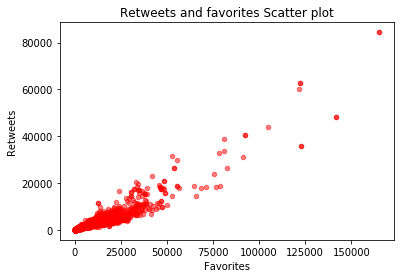

In [299]:
master_df.plot(kind = 'scatter', x = 'tweet_favorites', y = 'tweet_retweets', alpha = 0.5, color = 'red')
plt.xlabel('Favorites')
plt.ylabel('Retweets')
plt.title('Retweets and favorites Scatter plot')

Text(0,0.5,'dog_breed')

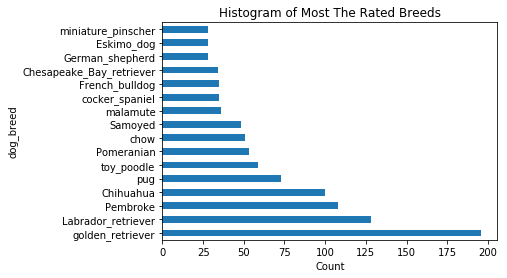

In [303]:
df_by_breed = master_df.groupby('dog_breed').filter(lambda x: len(x) >= 25)

df_by_breed['dog_breed'].value_counts().plot(kind = 'barh')
plt.title('Histogram of Most The Rated Breeds')
plt.xlabel('Count')
plt.ylabel('dog_breed')

Text(0.5,1,'Dog Gender Partitions')

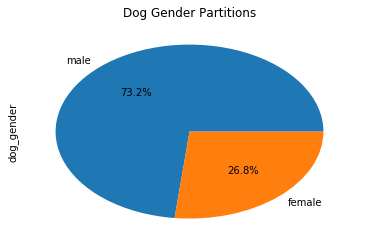

In [304]:
master_df[master_df['dog_gender'].notnull()]['dog_gender'].value_counts().plot(kind = 'pie', autopct='%1.1f%%')
plt.title('Dog Gender Partitions')

(-1.2884420747098386,
 1.2424646410235636,
 -1.2129642814258061,
 1.2098120741125542)

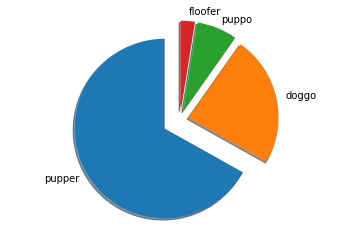

In [305]:
dog_stage_count = list(master_df[master_df['dog_stage'] != 'None']['dog_stage'].value_counts())[0:4]
dog_stages = master_df[master_df['dog_stage'] != 'None']['dog_stage'].value_counts().index.tolist()[0:4]
explode = (0.2, 0.1, 0.1, 0.1) 

fig1, ax1 = plt.subplots()
ax1.pie(dog_stage_count, explode = explode, labels = dog_stages, shadow = True, startangle = 90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


Text(0.5,1,'')

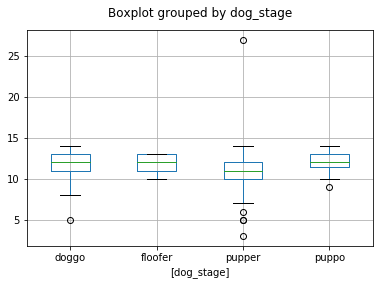

In [306]:

# Plot the dog stages with ratings
master_df[master_df['dog_stage'] != 'None'].boxplot(column = ['rating_numerator'], by = ['dog_stage'])
plt.title('')